# Lab 4 Exploration: LIDAR

In this notebook, we will learn how to use the racecar's LIDAR to measure distance and find closest points.

Throughout this notebook, **<font style="color:red">text in bold red</font>** indicates a change you must make to the following code block before running it.


## Table of Contents
1. [Getting Started](#GettingStarted)
1. [Gathering LIDAR Data](#GatheringLidarData)
1. [Visualizing LIDAR Data](#VisualizingLidarData)
1. [Handling Noise](#HandlingNoise)
1. [Closest Point](#ClosestPoint)

<a id="ROS2 Node Setup"></a>
## 0. ROS2 Node Setup

Run the following two scripts to set up the ROS2 subscriber node that retrieves color images. After the first time the scripts have been run, they must not be run again, else the system will crash.

In [1]:
# Import Asynchronous ROS2 initialization script
# ROS2
import rclpy as ros2
from rclpy.qos import qos_profile_sensor_data
from sensor_msgs.msg import LaserScan
from cv_bridge import CvBridge, CvBridgeError
import threading

# Create node
ros2.init()

In [151]:
import cv2 as cv
import numpy as np
from nptyping import NDArray

class LidarReal():
    # The ROS topic from which we get Lidar data
    __SCAN_TOPIC = "/scan"
    _NUM_SAMPLES = 720
    
    def __init__(self):
        # ROS node
        self.node = ros2.create_node("scan_sub")

        # subscribe to the scan topic, which will call
        # __scan_callback every time the lidar sends data
        self.__scan_sub = self.node.create_subscription(
            LaserScan, self.__SCAN_TOPIC, self.__scan_callback, qos_profile_sensor_data
        )

        self.__samples = np.empty(0)
        self.__samples_new = np.empty(0)

    # LIDAR Scan returns value in meters, multiplying by 100 to be processed in cm
    # LIDAR Scan reversed, flipping order of data entry to correct for CW spin
    def __scan_callback(self, data):
        self.__samples_new = np.flip(np.multiply(np.array(data.ranges), 100))
        
    def __update(self):
        self.__samples = self.__samples_new

    def get_samples(self) -> NDArray[720, np.float32]:
        return self.__samples

    def get_samples_async(self) -> NDArray[720, np.float32]:
        ros2.spin_once(self.node)
        return self.__samples_new
    
    def get_num_samples(self):
        return self._NUM_SAMPLES

<a id="GettingStarted"></a>
## 1. Getting Started

**<font style="color:red">If you are running the car in RacecarSim, set `isSimulation` to `True`</font>**. Leave `isSimulation` `False` if you are using a physical car.

In [152]:
# TODO: Update isSimulation if necessary
isSimulation = False

Next, we will import the necessary libraries for this notebook, including Python libraries (`cv`, `numpy`, etc.) and the Racecar library (`racecar_core`).

In [153]:
# Import Python libraries
import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import statistics
from nptyping import NDArray
from typing import Any, Tuple, List, Optional

# Import Racecar library
import sys
sys.path.append("../../library")
import racecar_core
import racecar_utils as rc_utils

Finally, we will create a racecar object.  If this step fails, make sure that `isSimulation` has the correct value.

In [154]:
# Create Racecar
rc = LidarReal()

<a id="GatheringLidarData"></a>
## 2. Gathering LIDAR Data
The racecar's LIDAR data is stored as a one-dimensional numpy array of 720 distance measurements.  Each measurement is 1/2 of a degree apart, ordered clockwise, with the 0th entry directly in front of the car.

In Jupyter Notebook, we can access the car's LIDAR data using `rc.lidar.get_samples_async()`.  Outside of Jupyter Notebook, we must use `rc.lidar.get_samples()` instead.

In [155]:
# Access the current LIDAR scan
scan = rc.get_samples_async()
# [print(f"{deg}: {dist}") for deg, dist in enumerate(scan)]

Let's access the measurements directly in front of and behind the car.

In [156]:
# Calculate and show the forward and rear distances
forward_distance = scan[0]
print(f"Forward distance: {forward_distance:.2f} cm")

rear_distance = scan[360]
print(f"Rear distance: {rear_distance:.2f} cm")

Forward distance: 0.00 cm
Rear distance: 0.00 cm


**<span style="color:red">Set `left_distance` and `right_distance` in the following code block to the LIDAR measurements directly to the left and directly to the right of the car.</span>**

In [157]:
# TODO: Calculate and show the left and right distances
left_distance = scan[270]
print(f"Left distance: {left_distance:.2f} cm")

right_distance = scan[90]
print(f"Right distance: {right_distance:.2f} cm")

Left distance: 0.00 cm
Right distance: 0.00 cm


<a id="VisualizingLidarData"></a>
## 3. Visualizing LIDAR data

In this section, we will write a function to convert LIDAR data into a color image providing a top-down view of the data.  We will use the following approach:

1. Create an all-black BGR image (a 3D numpy array ordered rows, columns, color channels) of the specified radius.
1. Denote the car by drawing a green dot at the center of the image with [`rc_utils.draw_circle`](https://mitll-racecar.readthedocs.io/en/latest/racecar_utils.html#racecar_utils.draw_circle).
1. For each LIDAR sample, set the corresponding pixel to red. We can calculate the angle of each sample based on its index in the scan.  By scaling the distance such that `max_range` is the edge of the image, we can convert this angle and distance into a row and column in the image.
1. `highlighted_samples` contains a list of `(angle, distance)` measurements that we wish to highlight with light blue dots. These can be plotted similarly to the samples in the previous step and drawn with `rc_utils.draw_circle`.
1. Display the color image in the Jupyter Notebook with Matplotlib.

The result should look similar to the LIDAR visualization shown in the left sidebar of RacecarSim.

**<span style="color:red">Finish implementing this approach in the `show_lidar` function below.</span>**

In [184]:
def show_lidar(
    scan: NDArray[Any, np.float32],
    radius: int = 128,
    max_range: int = 400,
    highlighted_samples: List[Tuple[int, int]] = []
) -> None:
    """
    Displays a visual representation of a LIDAR scan in Jupyter Notebook.
    
    Args:
        scan: The LIDAR scan to show.
        radius: Half of the width and height (in pixels) of the generated image.
        max_range: The farthest distance to show in the image in cm. Any sample past this range is not shown.
        highlighted_samples: A list of samples in (angle, distance) format to show as a blue dot.
    """    
    # Create a square black image with the requested radius
    image = np.zeros((2 * radius, 2 * radius, 3), np.uint8, "C")
    # 720 samples

    CAR_DOT_RADIUS = 2
    
    rc_utils.draw_circle(image, (radius, radius), rc_utils.ColorBGR.green.value, CAR_DOT_RADIUS)

    for half_deg, value in enumerate(scan):
        if value == 0:
            continue
        rad = half_deg * math.pi / 180.0 / 2.0
        x = round(radius + value * math.cos(rad))
        y = round(radius + value * math.sin(rad))
        if x > image.shape[0] or x < 0 or y > image.shape[0] or y < 0:
            continue
        rc_utils.draw_circle(image, (x, y), rc_utils.ColorBGR.red.value, CAR_DOT_RADIUS)

    
    HIGHLIGHT_DOT_RADIUS = 2
    for deg, value in highlighted_samples:
        rad = deg * math.pi / 180.0
        x = round(radius + value * math.cos(rad))
        y = round(radius + value * math.sin(rad))
        if x > image.shape[0] or x < 0 or y > image.shape[0] or y < 0:
            continue
        rc_utils.draw_circle(image, (x, y), rc_utils.ColorBGR.light_blue.value, HIGHLIGHT_DOT_RADIUS)

    # Show the image with Matplotlib
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

Let's use this function to visualize our LIDAR scan.

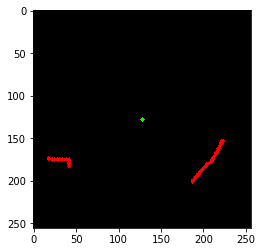

In [185]:
scan = rc.get_samples_async()
show_lidar(scan)

For now, we will test out the `highlighted_samples` feature by highlighting points 100 cm in each cardinal direction.

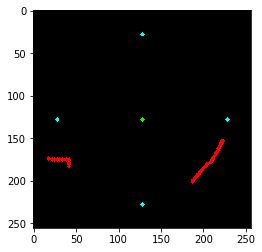

In [187]:
show_lidar(scan, highlighted_samples=[(0, 100), (90, 100), (180, 100), (270, 100)])

<a id="HandlingNoise"></a>
## 4. Handling Noise

Just like depth images, LIDAR data is also subject to noise and null values. To help combat this, we will once again average several neighboring samples across an *angle window* instead of relying on a single measurement. For example, if we want to measure the distance at 60 degrees with a 4 degree window angle, we would average all of the samples from 58 to 62 degrees.  To reduce the impact of null values, we should not consider any 0.0 measurement in our average.

**<span style="color:red">Implement this approach in `get_lidar_average_distance`</span>**. You may wish to use a Python [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions).

In [188]:
def get_lidar_average_distance(
    scan: NDArray[Any, np.float32], angle: float, window_angle: float = 4
) -> float:
    """
    Finds the average distance of the object at a particular angle relative to the car.

    Args:
        scan: The samples from a LIDAR scan
        angle: The angle (in degrees) at which to measure distance, starting at 0
            directly in front of the car and increasing clockwise.
        window_angle: The number of degrees to consider around angle.

    Returns:
        The average distance of the points at angle in cm.

    Note:
        Ignores any samples with a value of 0.0 (no data).
        Increasing window_angle reduces noise at the cost of reduced accuracy.
    """
    # TODO: average the samples in the specified window
    
    
    angle = angle % 360
    
    min_angle = round((angle - window_angle / 2) % 360 * 2)
    max_angle = round((angle + window_angle / 2) % 360 * 2)
    
    if max_angle == min_angle:
        return 0
    
    order = 1
    
    if max_angle < min_angle:
        order = -1
    
    slice = scan[min_angle:max_angle:order]
    
    return sum(slice) / len(slice)

Let's try it out. Increasing the window angle will decrease noise by including more samples, but will also decrease accuracy by including less relevant samples.

In [189]:
WINDOW_ANGLE = 6
rear_distance = get_lidar_average_distance(scan, 180, WINDOW_ANGLE)
print(f"Rear distance ({WINDOW_ANGLE} degree window): {rear_distance:.2f} cm")

Rear distance (6 degree window): 145.97 cm


`get_lidar_average_distance` must handle when the angle window passes over the edge of the array.  For example, with an angle of 0 and a window angle of 6, we must consider all samples in the range 357 to 3 degrees.

**<span style="color:red">If you have not done so already, update `get_lidar_average_distance` to support angle windows that cross the edge of the array.</span>**.

In [190]:
forward_distance = get_lidar_average_distance(scan, 0, WINDOW_ANGLE)
print(f"Forward distance ({WINDOW_ANGLE} degree window): {forward_distance:.2f} cm")

Forward distance (6 degree window): 114.05 cm


Finally, we must handle when there is no data in the specified angle window.  In this case, we should return `0.0`.

**<span style="color:red">If you have not done so already, update `get_lidar_average_distance` to return `0.0` when the specified range does not contain any data.</span>**.

In [191]:
null_scan = np.zeros(rc.get_num_samples(), np.float32)
forward_distance = get_lidar_average_distance(null_scan, 0, WINDOW_ANGLE)
print(f"Forward distance ({WINDOW_ANGLE} degree window) in null scan: {forward_distance:.2f} cm")

Forward distance (6 degree window) in null scan: 0.00 cm


<a id="ClosestPoint"></a>
## 5. Closest Point

We can use the LIDAR to find the angle of the closest object in 360 degrees around the car.  Just like with the depth image, we should convert null values to a large number so they are not considered for the minimum. An efficient way to do this is to shift down each value by a small amount (such as 0.01 cm) and then mod by a large number (such as 10,000 cm).  This way, 0.0 becomes -0.01, which after modding becomes 9,999.99 cm, a very large distance that will not interfere with the true minimum.

```
scan = (scan - 0.01) % 10000
```

In lecture, we saw an example of how to find the angle of the closest point using the Numpy [argmin](https://numpy.org/doc/1.19/reference/generated/numpy.argmin.html) function.

```
scan = (scan - 0.01) % 10000
angle = np.argmin(scan) * 360 / rc.lidar.get_num_samples()
```

However, we may only wish to consider samples within a particular range, such as samples ranging from 30 to 150 degrees. **<span style="color:red">Implement `get_closest_pixel` to find the angle and distance of the closest point within a specified window in a LIDAR scan</span>**.

In [198]:
def get_lidar_closest_point(
    scan: NDArray[Any, np.float32], window: Tuple[float, float] = (0, 360)
) -> Tuple[float, float]:
    """
    Finds the closest point from a LIDAR scan.

    Args:
        scan: The samples from a LIDAR scan.
        window: The degree range to consider, expressed as (min_degree, max_degree)

    Returns:
        The (angle, distance) of the point closest to the car within the specified
        degree window. All angles are in degrees, starting at 0 directly in front of the
        car and increasing clockwise. Distance is in cm.

    Note:
        Ignores any samples with a value of 0.0 (no data).

        In order to define a window which passes through the 360-0 degree boundary, it
        is acceptable for window min_degree to be larger than window max_degree.  For
        example, (350, 10) is a 20 degree window in front of the car.
    """
    # TODO: Return the (angle, distance) of the closest point within the specified window
    scan = (scan - 0.01) % 10000
    
    min_angle = window[0] % 360 * 2
    max_angle = window[1] % 360 * 2
    
    slice = scan[min_angle:max_angle]
    angle = np.argmin(slice) * 360 / rc.get_num_samples() + min_angle
    return (angle, scan[int(angle)])

Let's use `get_lidar_closest_point` to find the closest point to the right of the car.

Angle: 78.0 degrees
Distance: 93.3 cm


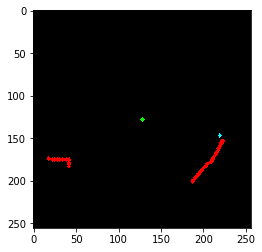

In [199]:
angle, distance = get_lidar_closest_point(scan, (30, 150))
print(f"Angle: {angle:.1f} degrees")
print(f"Distance: {distance:.1f} cm")

show_lidar(scan, highlighted_samples=[(angle, distance)])

Once again, we should handle when the specified degree range passes over the edge of our array.  **<span style="color:red">If you have not done so already, update `get_lidar_closest_point` to support negative angles and windows that cross the edge of the array.</span>**.

In [200]:
angle, distance = get_lidar_closest_point(scan, (-30, 30))
print(f"Angle: {angle:.1f} degrees")
print(f"Distance: {distance:.1f} cm")

show_lidar(scan, highlighted_samples=[(angle, distance)])

ValueError: attempt to get argmin of an empty sequence

You are now ready to begin on LIDAR labs `lab4a.py` and `lab4b.py`.  Good luck, and don't be afraid to ask questions!